In [11]:
#This model was inspired by these two examples:

#[1] https://www.kaggle.com/raghavkhemka/sarcasm-detection-using-bert-92-accuracy

#[2] https://www.kaggle.com/carmensandiego/sarcasm-detection-with-bert-val-accuracy-98-5

#Please note that I tried to save the model but I consistently got errors trying to recover it
#based on this trained model, the best F1 score I obtained was 0.732. I kept all the answer.txt
#submissions that beat the baseline, but please note that, because there is no model saved
#you might not be able to beat the baseline with the model (as it depends on the learning
#that happens during training)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf #using TensorFlow for the neural network
import matplotlib.pyplot as plt #To be able to plot accuracy and loss
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re,string

#These lines are commented since this is to be run locally
#from google.colab import drive
#drive.mount("/content/gdrive")

In [12]:
!pip install Transformers
from transformers import TFBertModel, BertTokenizer, AdamWeightDecay

#Here I am reading the files from <local directory>/data/
#Please create a "data" directory in the folder where you run this 
#workbook and place both train.jsonl and test.jsonl files in it
#You must have the same setup otherwise this section will throw an Exception

df = pd.read_json("./data/train.jsonl", lines=True)
labels = df.label.values
tweeets = df.response.values
df.head()

You should consider upgrading via the 'c:\users\user\anaconda3\python.exe -m pip install --upgrade pip' command.


,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y â€™ all gone â€œ both sides â€� the...


In [13]:
#download stopwords that we are going to use to filter tweets
nltk.download('stopwords')
stop = set(stopwords.words('english'))

#remove punctuation from tweets
punctuation = list(string.punctuation)
stop.update(punctuation)


#These are different functions I built to remove different parts of the tweets.
#I ended up using two or three of them in order to get my best reported results

def remove_emoji(text):
        emoji_patterns = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
        return emoji_patterns.sub(r'',text)

#Removing the @USER from tweets
def remove_tag_user(text):
    return re.sub('@USER', '', text)

#Remove hashtags symbols from tweets
def remove_hashtags(text):
    return re.sub('#', '', text)

#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

#Removed special symbols that were not captured by punctuation
def remove_special_symbols(text):
    text = re.sub('->', '', text)
    text = re.sub('“', '', text)
    text = re.sub('”', '', text)
    text = re.sub('\.','',text)
    return re.sub('’','', text)
  
#Convert labels to numbers
def convert_labels(text):
    text = re.sub('NOT_SARCASM', '0', text)
    text = re.sub('SARCASM', '1', text)
    return text

#Removing all the noisy text, note that most of the functions are now 
#commented. This is because I tested different alternatives and I got best
#results by just removing stopwords and special symbols (while keeping
#everything else)

def denoise_text(text):
    #text = remove_emoji(text)
    text = remove_stopwords(text)
    text = remove_special_symbols(text)
    #text = remove_tag_user(text)
    #text = remove_links(text)
    #text = remove_hashtags(text)
    #text = remove_punct(text)

    return text

#Apply function on review column
df['response']=df['response'].apply(denoise_text)
df['label']=df['label'].apply(convert_labels)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,response,context
0,1,@USER @USER @USER get obviously care would've...,[A minor child deserves privacy and should be ...
1,1,@USER @USER trying protest Talking labels labe...,[@USER @USER Why is he a loser ? He's just a P...
2,1,@USER @USER @USER makes insane money MOVIES Ei...,[Donald J . Trump is guilty as charged . The e...
3,1,@USER @USER Meanwhile Trump even release SAT s...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,1,@USER @USER Pretty Sure Anti-Lincoln Crowd Cla...,[Man ... y â€™ all gone â€œ both sides â€� the...


In [14]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name,do_lower_case = True)

#encoder method to tokenize tweets
#please note that I have changed the input_size vs. the cited work
def encoder(thetweets):
    ids = []
    for atweet in thetweets:
        encoding = tokenizer.encode_plus(atweet,max_length=64,truncation = True,add_special_tokens=True,return_token_type_ids=False,padding='max_length',return_attention_mask=False)
        ids.append(encoding['input_ids'])
    return ids

#Train test split
train_tweets,test_tweets, train_labels, test_labels  = train_test_split(tweeets,labels,test_size=0.2)

#encoding tweets
train_ids = encoder(train_tweets)
test_ids = encoder(test_tweets) 

In [15]:
#conversion of train and test tweets to tensors (to pass to model)
train_ids = tf.convert_to_tensor(train_ids)
test_ids = tf.convert_to_tensor(test_ids)

#casting of labels to tensors after casting them to float (otherwise it does not work :-\)
test_labels = tf.convert_to_tensor(test_labels.astype(np.float))
train_labels = tf.convert_to_tensor(train_labels.astype(np.float))


In [16]:
#the original model was found here:
#[1] https://www.kaggle.com/raghavkhemka/sarcasm-detection-using-bert-92-accuracy

#However I changed the dimensions and fine-tuned the rate of output
#as well as the optimizer, learning rate and loss function parameters
#I also trained the model myself, so in the end is a different instance

bert_encoder = TFBertModel.from_pretrained('bert-base-uncased')

input_word_ids = tf.keras.Input(shape=(64,), dtype=tf.int32, name="input_word_ids")  
#embedding's layer from BERT
embedding = bert_encoder([input_word_ids])

#Model consists of an embedding layer and two Dense layers
#Please note that I changed the number of nodes vs. the cited work
# in "Sarcasm Detection using the Pre-Trained BERT model from Transformers"
dense = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(embedding[0])
dense = tf.keras.layers.Dense(100, activation='relu')(dense)

#Dropout set at 40%
dense = tf.keras.layers.Dropout(0.4)(dense)

#Sigmoid function as we are doing a binary classification
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)    

#model definition, receiving tweets as input and the result from the sigmoid
#function as output
model = tf.keras.Model(inputs=[input_word_ids], outputs=output)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
#In this line I choose optimizer, loss function and metric to calculate loss
#Note that this is also different from cited work at [1]
#Sarcasm Detection using the Pre-Trained BERT model from Transformers

#According to the documentation found, Adamax is a better optimizer in models
#that deal with an embeddings layer, this is why I chose it instead of Adam
#I also test the AdamWeightDecay optimizer (recommended in Piazza posts), but
#I still got better results with Adamax.

#I used learning rate of 2e-5 based on BERT Paper (reference below)
#https://arxiv.org/pdf/1810.04805.pdf

model.compile(tf.keras.optimizers.Adamax(lr=2e-5,beta_1=0.9, beta_2=0.99), loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 64)]              0         
_________________________________________________________________
tf_bert_model_1 (TFBertModel ((None, 64, 768), (None,  109482240 
_________________________________________________________________
lambda_1 (Lambda)            (None, 768)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               76900     
_________________________________________________________________
dropout_75 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 109,559,241
Trainable params: 109,559,241
Non-trainable params: 0
________________________________________

In [18]:
#Here I train the model
#I use batch size = 8 to maximize the input that BERT can receive which is
#8 x 64 = 512 bytes. I also trained 3 epochs because in my experience
#given the setup and the dropouts, this is the number where I do not see
#overfitting (val_error does not increase). Additional epochs under the current
#setup would probably overfit the model

#Please note that this will run EXTREMELY slowly in a local environment. It is better to run it within
#something like Google Colab using GPU

history = model.fit(x = train_ids, y = train_labels, epochs = 3, verbose = 2, batch_size = 8, validation_data = (test_ids, test_labels))

Epoch 1/3
500/500 - 1909s - loss: 0.5881 - binary_accuracy: 0.6725 - val_loss: 0.5232 - val_binary_accuracy: 0.7320
Epoch 2/3
500/500 - 1768s - loss: 0.4734 - binary_accuracy: 0.7722 - val_loss: 0.5391 - val_binary_accuracy: 0.7370
Epoch 3/3
500/500 - 1692s - loss: 0.3935 - binary_accuracy: 0.8232 - val_loss: 0.5368 - val_binary_accuracy: 0.7550


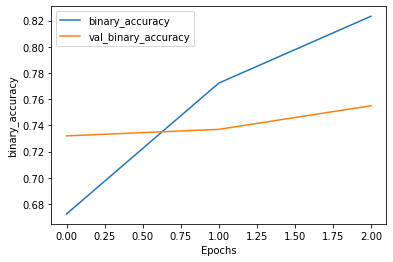

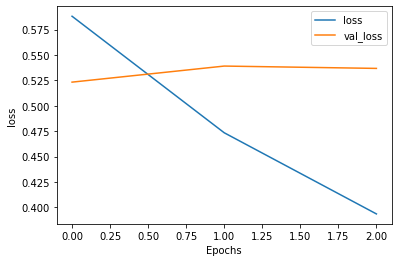

In [19]:
#Here I can check how the accuracy and loss functions change as I test different scenarios
#and prior to generating an answer.txt file to submit for competition purposes

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, 'binary_accuracy')
plot_graphs(history, 'loss')

In [20]:
#Here I bring the test tweets (with no labels), to run the REAL test (generating
# the file answer.txt and submitting to the competition)
df_test = pd.read_json("./data/test.jsonl", lines=True, encoding='utf-8')
df_test.head()

,id,response,context
0,twitter_1,"@USER @USER @USER My 3 year old , that just fi...","[Well now that ’ s problematic AF <URL>, @USER..."
1,twitter_2,@USER @USER How many verifiable lies has he to...,[Last week the Fake News said that a section o...
2,twitter_3,@USER @USER @USER Maybe Docs just a scrub of a...,[@USER Let ’ s Aplaud Brett When he deserves i...
3,twitter_4,@USER @USER is just a cover up for the real ha...,[Women generally hate this president . What's ...
4,twitter_5,@USER @USER @USER The irony being that he even...,"[Dear media Remoaners , you excitedly sharing ..."


In [21]:
df_test['response']=df_test['response'].apply(denoise_text)
df_test.head()

,id,response,context
0,twitter_1,@USER @USER @USER 3 year old finished reading ...,"[Well now that ’ s problematic AF <URL>, @USER..."
1,twitter_2,"@USER @USER many verifiable lies told 15,000+ ...",[Last week the Fake News said that a section o...
2,twitter_3,@USER @USER @USER Maybe Docs scrub coach mean...,[@USER Let ’ s Aplaud Brett When he deserves i...
3,twitter_4,@USER @USER cover real hate inside @USER left ...,[Women generally hate this president . What's ...
4,twitter_5,@USER @USER @USER irony even ask,"[Dear media Remoaners , you excitedly sharing ..."


In [22]:
#Here I create the same conditions for the test tweets
tweets_test = df_test.response.values
real_test_ids = encoder(tweets_test) 
real_test_ids = tf.convert_to_tensor(real_test_ids)

In [23]:
#get the list of predictions from the model (which are basically real numbers in the range [0,1])
pred = model.predict(real_test_ids)
pred

array([[0.10619712],
       [0.9159985 ],
       [0.37104142],
       ...,
       [0.5987929 ],
       [0.00151753],
       [0.17074263]], dtype=float32)

In [24]:
#Here I write the file in the local drive
#Anything above or equal to 0.5 is considered SARCASM
#and anything below is considered NOT_SARCASM
#This is the file I end up submitting to LiveDataLab

#I create the file in the local directory, and then I submit from there to the competition
answers = open("./answer.txt", "w")
num_test_tweets = len(pred)
for i in range(num_test_tweets):
    if(pred[i][0]<0.5):
        response="twitter_"+str(i+1)+",NOT_SARCASM\n"
        answers.write(response)
    else:
        response="twitter_"+str(i+1)+",SARCASM\n"
        answers.write(response)
answers.close()